# Punt plays for each season

Using the punt tracking data, punt data, and pff data, we want to match each punt with when it hits the ground or goes out of bounds (if it goes straight OoB).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

play_data = pd.read_csv('./data/plays.csv')
pff_data = pd.read_csv('./data/PFFScoutingData.csv')

discard_results = ['Non-Special Teams Result']#,'Blocked Punt']
punt_plays = play_data[(play_data['specialTeamsPlayType']=='Punt')&(~play_data['specialTeamsResult'].isin(discard_results))]
pff_punt = pff_data.merge(punt_plays[['gameId','playId']],on=['gameId','playId'],how='inner')

display((punt_plays['gameId']//10**6).value_counts())
print('Total plays: ' + str(len(punt_plays)))

2018    2128
2019    2008
2020    1667
2021     114
Name: gameId, dtype: int64

Total plays: 5917


#### Load each year's tracking data and keep only the football for punt plays

In [2]:
# 2018 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2018.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_18 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_18['time'] = pd.to_datetime(punt_fbtrack_18['time'])

# 2019 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2019.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_19 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_19['time'] = pd.to_datetime(punt_fbtrack_19['time'])

# 2020 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2020.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_20 = football_tracking.merge(punt_plays[['gameId','playId']],on=['gameId','playId'])
punt_fbtrack_20['time'] = pd.to_datetime(punt_fbtrack_20['time'])

# Combine all above tracking data
punt_fbtrack = pd.concat([punt_fbtrack_18,punt_fbtrack_19,punt_fbtrack_20]) \
                .sort_values(by=['gameId','playId','frameId']) \
                .drop(columns=['o','dir','nflId','displayName','jerseyNumber','position','team']) \
                .reset_index(drop=True)

## The goal is to find the first frame where the ball hits the ground after the punt

#### Useful functions that will be commonly used throughout the processing

In [3]:
# Create a table of events that occur during the punt play, removing a list of excluded events.
def event_table(df, exc_list=[]):
    df_trim = df[(~df['event'].isin(exc_list))&(df['event']!='None')].copy()
    df_trim['event_num'] = df_trim.groupby(['gameId','playId']).apply(lambda x: (x['event']!='').cumsum()) \
                                    .reset_index([0,1],drop=True)
    return pd.pivot_table(df_trim, values='event', index=['gameId','playId'],columns='event_num',aggfunc=lambda x: ''.join(x))


# Given a list of events that signal the landing frame of a play, pull out the landing frame.
# Further restriction of plays to a particular PFF Contact Type is accepted.
def find_landing_frame(df, accepted_events, contact_type = None):
    punts = df.copy()
    if contact_type != None:
        # Limit punt data to specific PFF Contact Type punts
        punts = select_contact_types(punts, contact_type)
    
    accept_frame = punts[punts['event'].isin(accepted_events)].drop_duplicates(subset=['gameId','playId'])
    
    temp = punts.merge(accept_frame[['gameId','playId','frameId']], on=['gameId','playId'],how='left')
    remaining_punts = temp[temp['frameId_y'].isna()][['gameId','playId']].drop_duplicates()
    
    return [accept_frame, remaining_punts]


# Pull the plays that match a particular PFF Contact Type
def select_contact_types(df, contact_type):
    return df.merge(pff_punt[pff_punt['kickContactType'].isin(contact_type)][['gameId','playId']])
    
    


drop_event_list = ['ball_snap','line_set','safety','pass_forward','fumble','tackle','first_contact',
                   'fumble_offense_recovered','penalty_flag','fumble_defense_recovered','lateral',
                   'pass_outcome_caught','penalty_accepted','play_action','touchdown','shift','man_in_motion',
                   'huddle_break_offense','huddle_start_offense']
# display(event_table(punt_fbtrack,drop_event_list).apply(pd.Series.value_counts))

# a, b = find_landing_frame(punt_fbtrack,cc_events,['CC'])
# display(a)
# display(b)


# cc_events = ['fair_catch','punt_received','punt_land','punt_downed','punt_muffed']
# oob_events = ['out_of_bounds','punt_land','kick_received','punt_muffed','punt_received','fair_catch']
# bc_events = ['punt_received','fair_catch','punt_muffed']
# dez_events = ['punt_land','touchback']

### Separate DEZ and OOB from the remaining punts.

These events have special conditions, where events that typically signal the ball landing may occur after the ball has exited the field of play.

In [4]:
# Select OOB and DEZ events and find all frames where the ball is out of bounds or past the endzones
# Label these frames with a new event (if current event is None) to label that the ball has left the field of play.
check_inbound_punts = select_contact_types(punt_fbtrack,['OOB','DEZ'])
check_inbound_punts.loc[
    ((check_inbound_punts['x']<10)|(check_inbound_punts['x']>110) # Touchback
    |(check_inbound_punts['y']<0)|(check_inbound_punts['y']>160/3)) # Out of Bound
    &(check_inbound_punts['event']=='None'), # Do not replace other events
    'event'] = 'out_bound'

outbound_events = ['out_bound','out_of_bounds','punt_land','kick_received','punt_muffed','punt_received','fair_catch','touchback']
outbound_plays,b=find_landing_frame(check_inbound_punts, outbound_events)
display(outbound_plays)
display(b)

,time,x,y,s,a,dis,event,frameId,gameId,playId,playDirection
62,2018-09-09 17:05:14.200,73.16,53.69,9.81,5.23,1.13,out_bound,63,2018090901,118,right
145,2018-09-09 20:37:14.800,65.81,53.76,9.57,11.06,1.43,out_bound,61,2018090901,4965,right
229,2018-09-09 18:50:53.200,60.44,-0.29,4.55,4.07,0.61,out_bound,74,2018090907,2357,left
311,2018-09-09 19:14:23.300,24.05,53.66,4.63,0.51,0.47,out_bound,70,2018090907,2877,left
387,2018-09-11 02:07:16.900,60.90,53.49,9.94,2.47,1.08,out_bound,65,2018091000,3527,right
...,...,...,...,...,...,...,...,...,...,...,...
29604,2020-12-28 01:39:28.300,9.85,13.12,6.91,3.18,0.71,out_bound,71,2020122713,474,left
29689,2020-12-29 02:37:56.600,28.23,51.37,11.80,2.84,1.22,punt_received,72,2020122800,2025,left
29781,2021-01-03 20:03:13.100,21.47,53.58,5.56,5.23,0.58,punt_land,73,2021010300,2755,left
29861,2021-01-03 19:51:03.700,29.83,-0.46,10.25,3.65,1.04,out_bound,70,2021010304,2404,left


,gameId,playId


## All remaining plays should have the ball land/caught in bounds

Using Hang Time from PFF data to find the frame where the ball lands will be the primary method we use.  There is some inconsistency with event labels in the tracking data, thus we do not rely on any particular event (such as punt_land etc).  However, we can see how well the hang time method corresponds to the nearest events in the tracking data.

Note, there is 1 play where the punt event is clearly mistimed.  We wil manually exclude this event in the first part of the analysis.

In [5]:
# Look at non-OOB/DEZ punt plays
# Add hangTime from PFF data to the frame where there is a punt or autoevent_kick event in the tracking data
# This time gives a frame where the ball is recorded to land.
# Most of the times, this frame will not have an event listed, but it will be very close to a large number of possible events
in_plays = punt_fbtrack.merge(pff_punt[~pff_punt['kickContactType'].isin(['OOB','DEZ'])][['gameId','playId','hangTime']])
ball_data_oob = in_plays[((in_plays['y']<0)|(in_plays['y']>160/3))&(in_plays['frameId']<30)].drop_duplicates(subset=['gameId','playId'])
ball_data_oob['Drop'] = 'Yes'
in_plays = in_plays.merge(ball_data_oob[['gameId','playId','Drop']],how='left')
in_plays.drop(in_plays[in_plays['Drop']=='Yes'].index,inplace=True)#.drop(columns=['Drop'],inplace=True)

punt_frames = in_plays[in_plays['event'].isin(['punt','autoevent_kickoff'])].drop_duplicates(subset=['gameId','playId'],keep='last').copy()
punt_frames['landFrame'] = punt_frames['frameId'] + np.ceil(10*punt_frames['hangTime'])

# One play has the 'punt'-event frame clearly with significant error, so we exclude this event.
punt_frames.drop(punt_frames[(punt_frames['gameId']==2018112507)&(punt_frames['playId']==560)].index,inplace=True)

# Save the frames equal to the calculated landing frame
in_plays = in_plays.merge(punt_frames[['gameId','playId','landFrame']],how='left')
htfmpunt_plays = in_plays[in_plays['frameId']==in_plays['landFrame']].copy()
htfmpunt_plays['Found'] = 'Yes'

# Filter out the plays that cannot be found this way
in_plays_remain = in_plays.merge(htfmpunt_plays[['gameId','playId','Found']],how='left')
in_plays_remain = in_plays_remain[in_plays_remain['Found'].isna()]
htfmpunt_plays = htfmpunt_plays.iloc[:,:-3]
display(htfmpunt_plays)
display(in_plays_remain)

,time,x,y,s,a,dis,event,frameId,gameId,playId,playDirection,hangTime
77,2018-09-07 01:18:21.700,72.61,39.18,3.27,11.31,0.82,punt_received,78,2018090600,366,right,4.46
203,2018-09-07 01:40:33.200,96.45,39.01,7.59,3.18,0.87,None,76,2018090600,872,right,4.35
319,2018-09-07 01:46:40.900,69.30,48.70,3.56,11.83,0.41,None,84,2018090600,973,right,4.98
405,2018-09-07 02:22:21.400,20.49,43.54,3.70,5.67,0.57,None,78,2018090600,1850,left,4.53
510,2018-09-07 02:26:22.600,92.21,35.84,2.66,7.66,0.45,None,81,2018090600,1989,right,4.62
...,...,...,...,...,...,...,...,...,...,...,...,...
611404,2021-01-03 22:17:17.400,45.37,2.87,7.91,2.77,0.61,punt_received,77,2021010315,1359,left,4.50
611519,2021-01-03 22:23:15.500,92.58,11.68,5.89,9.63,0.65,punt_received,81,2021010315,1479,right,4.80
611631,2021-01-03 23:07:00.800,78.69,27.04,4.13,13.48,0.41,None,67,2021010315,2235,right,3.36
611766,2021-01-03 23:20:46.600,88.41,32.99,7.35,2.67,0.54,punt_received,80,2021010315,2497,right,4.69


,time,x,y,s,a,dis,event,frameId,gameId,playId,playDirection,hangTime,Drop,landFrame,Found
16280,2018-09-16 17:17:51.000,24.60,29.71,0.0,0.00,0.00,None,1,2018091602,365,right,NaN,NaN,NaN,NaN
16281,2018-09-16 17:17:51.100,24.60,29.71,0.0,0.00,0.00,None,2,2018091602,365,right,NaN,NaN,NaN,NaN
16282,2018-09-16 17:17:51.200,24.60,29.71,0.0,0.00,0.00,None,3,2018091602,365,right,NaN,NaN,NaN,NaN
16283,2018-09-16 17:17:51.300,24.60,29.71,0.0,0.00,0.00,None,4,2018091602,365,right,NaN,NaN,NaN,NaN
16284,2018-09-16 17:17:51.400,24.60,29.71,0.0,0.00,0.00,None,5,2018091602,365,right,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578155,2020-12-20 21:39:11.000,37.08,24.02,0.0,0.01,0.01,None,69,2020122003,881,right,NaN,NaN,NaN,NaN
578156,2020-12-20 21:39:11.100,37.08,24.02,0.0,0.01,0.00,None,70,2020122003,881,right,NaN,NaN,NaN,NaN
578157,2020-12-20 21:39:11.200,37.08,24.03,0.0,0.01,0.01,None,71,2020122003,881,right,NaN,NaN,NaN,NaN
578158,2020-12-20 21:39:11.300,37.08,24.03,0.0,0.00,0.00,None,72,2020122003,881,right,NaN,NaN,NaN,NaN


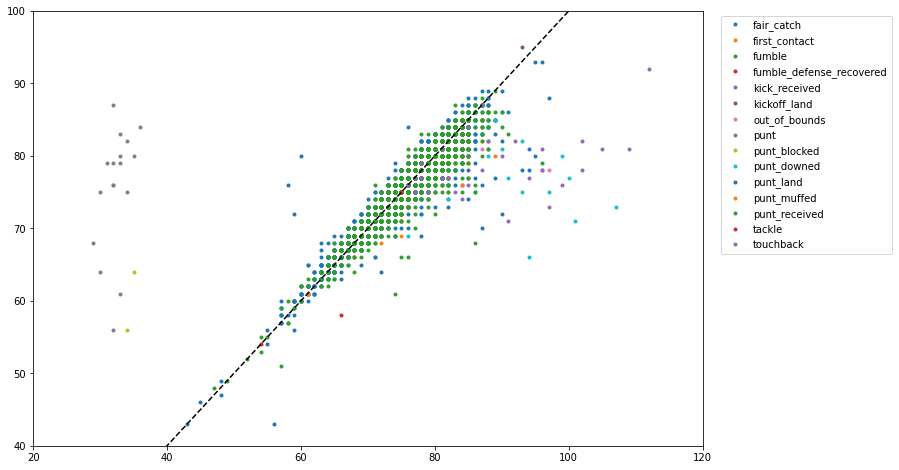

In [6]:
in_plays['frames_from_land'] = np.abs(in_plays['frameId'] - in_plays['landFrame'])

fig,ax = plt.subplots(figsize=(12,8))
exclude_list = ['None','penalty_flag','line_set','ball_snap','man_in_motion']
for a,b in in_plays[~in_plays['event'].isin(exclude_list)].sort_values('frames_from_land').groupby(['gameId','playId']).first().groupby('event'):
    ax.plot(b['frameId'],b['landFrame'],'.',label=a)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.plot(np.linspace(0,100,10),np.linspace(0,100,10),'k--')
plt.xlim(20,120)
plt.ylim(40,100)
plt.show()

#### Look at events with large values between events and landing frame

In [7]:
ordered_events = in_plays[(in_plays['event']!='None')&(~in_plays['frames_from_land'].isna())].sort_values(['gameId','playId','frames_from_land'],ascending=True).copy()
ordered_events['order'] = ordered_events.groupby(['gameId','playId']).cumcount()
nearest_events_to_land = pd.pivot_table(ordered_events,values='event',index=['gameId','playId'],columns='order',aggfunc=lambda x: ''.join(x))
nearest_events_to_land

order                          0              1              2          3  \
gameId     playId                                                           
2018090600 366     punt_received  first_contact         tackle       punt   
           872         punt_land      touchback           punt  ball_snap   
           973        fair_catch           punt      ball_snap        NaN   
           1850        punt_land    punt_downed           punt  ball_snap   
           1989    punt_received  first_contact         tackle       punt   
...                          ...            ...            ...        ...   
2021010315 1359    punt_received  first_contact         tackle       punt   
           1479    punt_received  first_contact         tackle       punt   
           2235    punt_received           punt  first_contact     tackle   
           2497    punt_received  first_contact         tackle       punt   
           3258       fair_catch           punt      ball_snap        NaN   

order                      4    5    6    7    8  
gameId     playId                                 
2018090600 366     ball_snap  NaN  NaN  NaN  NaN  
           872           NaN  NaN  NaN  NaN  NaN  
           973           NaN  NaN  NaN  NaN  NaN  
           1850          NaN  NaN  NaN  NaN  NaN  
           1989    ball_snap  NaN  NaN  NaN  NaN  
...                      ...  ...  ...  ...  ...  
2021010315 1359    ball_snap  NaN  NaN  NaN  NaN  
           1479    ball_snap  NaN  NaN  NaN  NaN  
           2235    ball_snap  NaN  NaN  NaN  NaN  
           2497    ball_snap  NaN  NaN  NaN  NaN  
           3258          NaN  NaN  NaN  NaN  NaN  

[5520 rows x 9 columns]

In [8]:
temp = ordered_events.groupby(['gameId','playId']).first()
large_time = punt_plays.merge(temp[temp['frames_from_land']>15].reset_index([0,1])[['gameId','playId','event','x','frameId','landFrame']])
large_time

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,event,x,frameId,landFrame
0,2018090900,2996,(10:10) (Punt formation) C.Bojorquez punts 46 ...,3,4,11,BUF,Punt,Out of Bounds,46903.0,...,0,NaN,46.0,NaN,46,34,punt,22.46,33,61.0
1,2018090907,3105,"(13:55) R.Dixon punts 59 yards to end zone, Ce...",4,4,7,NYG,Punt,Touchback,43517.0,...,13,NaN,59.0,NaN,39,69,touchback,-4.21,105,81.0
2,2018091606,1028,"(14:12) C.Johnston punts 45 yards to end zone,...",2,4,8,PHI,Punt,Touchback,45603.0,...,0,NaN,45.0,NaN,25,55,touchback,9.92,91,71.0
3,2018092000,4219,"(1:05) B.Colquitt punts 29 yards to NYJ 6, Cen...",4,4,2,CLE,Punt,Downed,34723.0,...,17,NaN,29.0,NaN,29,45,punt_land,15.32,87,70.0
4,2018093004,1181,"(14:20) R.Sanchez punts 37 yards to HOU 15, Ce...",2,4,6,IND,Punt,Fair Catch,45153.0,...,14,NaN,37.0,NaN,37,58,fair_catch,81.32,60,80.0
5,2018093004,1631,"(8:58) T.Daniel punts 47 yards to IND 9, Cente...",2,4,8,HOU,Punt,Fair Catch,46810.0,...,14,NaN,47.0,NaN,47,66,fair_catch,36.01,58,76.0
6,2018093007,3113,(8:06) (Punt formation) C.Johnston punts 46 ya...,4,4,6,PHI,Punt,Return,45603.0,...,17,NaN,46.0,0.0,46,81,punt_received,35.22,86,68.0
7,2018093012,2538,(10:11) (Punt formation) S.Koch punts 41 yards...,3,4,10,BAL,Punt,Touchback,31018.0,...,14,NaN,41.0,NaN,21,69,touchback,117.99,96,78.0
8,2018100712,2268,"(9:37) T.Daniel punts 61 yards to end zone, Ce...",3,4,6,HOU,Punt,Touchback,46810.0,...,13,NaN,61.0,NaN,41,71,punt_downed,12.62,100,77.0
9,2018102105,2090,"(1:23) K.Huber punts 57 yards to end zone, Cen...",2,4,7,CIN,Punt,Touchback,34593.0,...,7,NaN,57.0,NaN,37,67,touchback,9.09,94,77.0


## Remaining plays that land in bounds

Some plays have the ball entirely out of bounds, which we will remove for now.

In [9]:
no_ht = in_plays_remain[in_plays_remain['hangTime'].isna()].copy()
no_lt = in_plays_remain[(~in_plays_remain['hangTime'].isna())&(in_plays_remain['landFrame'].isna())].iloc[:,:-2].copy()
no_frame = in_plays_remain[(~in_plays_remain['hangTime'].isna())&(~in_plays_remain['landFrame'].isna())].copy()

### No Landing Time

These events occur when no 'punt' event frame is found.  This can be easily resolved by adding operationTime and hangTime to the ball_snap frame.

In [10]:
no_lt = no_lt.merge(pff_punt[['gameId','playId','operationTime']])
snap_frames = no_lt[no_lt['event']=='ball_snap'].copy()
snap_frames['landTime'] = snap_frames['frameId'] + np.floor(10*(no_lt['operationTime']+no_lt['hangTime']))
no_lt = no_lt.merge(snap_frames[['gameId','playId','landTime']])

### Landing Frame after last frame of the tracking data

11 plays have tracking data end before the punt lands

3 of these plays are from the same game, with the data ending several frames before the landing frame

The remaining 8 plays end 3 or fewer frames early.

In [11]:
no_frame_last = no_frame.drop_duplicates(subset=['gameId','playId'],keep='last')
no_frame_last_keep = no_frame_last[no_frame_last['landFrame'] - no_frame_last['frameId']<=3]
no_frame_last_remove = no_frame_last[no_frame_last['landFrame'] - no_frame_last['frameId']>3]

In [12]:
no_frame_keepevents = no_frame.merge(no_frame_last_keep[['gameId','playId']])
no_frame_keepevents[no_frame_keepevents['event']!='None']

,time,x,y,s,a,dis,event,frameId,gameId,playId,playDirection,hangTime,Drop,landFrame,Found
10,2018-12-02 18:30:58.500,42.35,23.84,2.65,11.46,0.26,ball_snap,11,2018120205,706,right,4.35,NaN,76.0,NaN
31,2018-12-02 18:31:00.600,34.40,24.36,6.46,2.09,0.57,punt,32,2018120205,706,right,4.35,NaN,76.0,NaN
65,2018-12-02 18:31:04.000,71.72,46.89,6.62,2.71,0.69,punt_downed,66,2018120205,706,right,4.35,NaN,76.0,NaN
73,2018-12-02 18:31:04.800,75.01,49.46,3.24,7.17,0.33,punt_land,74,2018120205,706,right,4.35,NaN,76.0,NaN
85,2019-10-20 17:41:57.900,50.60,23.87,0.01,0.02,0.00,ball_snap,11,2019102002,1017,left,4.61,NaN,79.0,NaN
106,2019-10-20 17:42:00.000,60.60,23.97,4.71,1.81,0.43,punt,32,2019102002,1017,left,4.61,NaN,79.0,NaN
162,2019-10-27 20:06:24.700,45.90,30.31,0.05,0.02,0.01,ball_snap,11,2019102705,3957,right,5.09,NaN,82.0,NaN
182,2019-10-27 20:06:26.700,36.09,29.39,5.41,3.02,0.52,punt,31,2019102705,3957,right,5.09,NaN,82.0,NaN
232,2019-10-27 20:06:31.700,86.12,31.33,3.95,3.77,0.40,fair_catch,81,2019102705,3957,right,5.09,NaN,82.0,NaN
243,2019-12-01 21:28:00.100,43.07,29.77,15.18,0.41,1.15,ball_snap,11,2019120109,118,right,3.87,NaN,72.0,NaN


### No Hang Time

42 Total events

6 are actual punts which were deflected.  We can use kick length and events during tracking to find the ball landing.  Of these events, 4 have events that can be used. The remaining two can be manually found.

gameId = 2018102111
playId = 3651
ball bounces on frame 38.

gameId = 2020100401
playId = 211
ball bounces on frame 54.


36 are blocked punts > For now, these events will be discarded.

In [13]:
no_ht_kct = no_ht.merge(pff_punt[['gameId','playId','kickContactType']]).drop(columns=['hangTime','landFrame','Found'])
no_ht_kct = no_ht_kct.merge(punt_plays[['gameId','playId','playDescription','specialTeamsResult','kickLength']])
no_ht_kct.drop_duplicates(subset=['gameId','playId'])['specialTeamsResult'].value_counts()

Blocked Punt    36
Downed           4
Fair Catch       1
Return           1
Name: specialTeamsResult, dtype: int64

In [14]:
no_ht_punts,unfound = find_landing_frame(no_ht_kct[(no_ht_kct['specialTeamsResult']!='Blocked Punt')],['fair_catch','punt_received','punt_land'])
unfound['frameId'] = np.array([38,54])
no_ht_punts = pd.concat([no_ht_punts,no_ht_kct.merge(unfound)])

#### Blocked punts

In [15]:
blocked_punts = no_ht_kct[(no_ht_kct['specialTeamsResult']=='Blocked Punt')].drop(columns=['Drop','kickContactType','specialTeamsResult','kickLength'])
check_block = blocked_punts[~blocked_punts['event'].isin(['None','punt','punt_blocked','line_set','penalty_flag','man_in_motion'])].copy()
check_block['event_num'] = check_block.groupby(['gameId','playId']).cumcount()
blocked_punts = blocked_punts.merge(pd.pivot_table(check_block,values='frameId',index=['gameId','playId'],columns='event_num')[[0,1]].reset_index([0,1]))
block_frames = blocked_punts[(blocked_punts['frameId']<=blocked_punts[1])&(blocked_punts['frameId']>=blocked_punts[0])]
block_frames = block_frames.merge(block_frames.groupby(['gameId','playId'])['x'].first().reset_index([0,1]).rename({'x':'first_x'},axis=1))
#block_frames.drop_duplicates(subset=['gameId','playId'])

In [16]:
block_frames['x_dist_from_first'] = (block_frames['x']-block_frames['first_x'])*(-1)**(block_frames['playDirection']=='left')
#block_frames#[block_frames['x_dist_from_first']>0]

### Miscellaneous

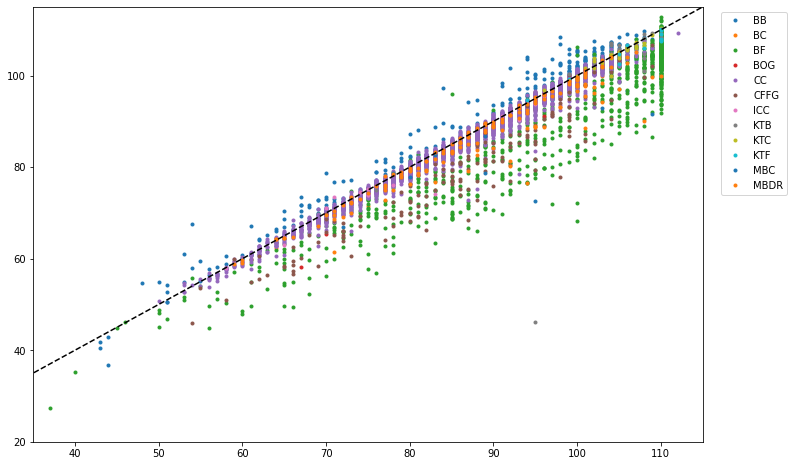

In [17]:
test = punt_plays.merge(in_plays[in_plays['frameId']==in_plays['landFrame']][['gameId','playId','x','playDirection']] \
                        .drop_duplicates(subset=['gameId','playId'])) \
                        .merge(pff_punt[['gameId','playId','kickContactType']])
test['a'] = test['absoluteYardlineNumber'] + test['kickLength']*(-1)**(test['playDirection']=='left')

# Transform all play into right-directional data
test['x'] = 60 - (60-test['x'])*(-1)**(test['playDirection']=='left')
test['a'] = 60 - (60-test['a'])*(-1)**(test['playDirection']=='left')

#[test['kickContactType']=='CC']
fig,ax = plt.subplots(figsize=(12,8))
for a,b in test.groupby('kickContactType'):
    ax.plot(b['a'],b['x'],'.',label=a)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.plot(np.linspace(0,120,10),np.linspace(0,120,10),'k--')
plt.xlim(35,115)
plt.ylim(20,115)
plt.show()

## Combine all data on landing frame

In [18]:
print(len(outbound_plays),len(htfmpunt_plays),len(no_lt[no_lt['frameId']==no_lt['landTime']]),len(no_frame_last_keep),len(no_ht_punts))
print(len(ball_data_oob),len(no_frame_last_remove.drop_duplicates(subset=['gameId','playId'])),len(blocked_punts.drop_duplicates(subset=['gameId','playId'])))

349 5509 2 8 6
4 3 36


In [19]:
landFrame_data = pd.concat([outbound_plays,htfmpunt_plays,no_lt[no_lt['frameId']==no_lt['landTime']],no_frame_last_keep,no_ht_punts],
          ignore_index=True)
landFrame_data = landFrame_data[['time','x','y','frameId','event','gameId','playId','playDirection']]
landFrame_data = landFrame_data.merge(pff_punt[['gameId','playId','hangTime']])

punt_frame_noht = punt_fbtrack[punt_fbtrack['event']=='punt'] \
    .merge(landFrame_data[landFrame_data['hangTime'].isna()][['gameId','playId','frameId']],on=['gameId','playId'])

punt_frame_noht['hangTime'] = (punt_frame_noht['frameId_y'] - punt_frame_noht['frameId_x'])/10

landFrame_data = landFrame_data.merge(punt_frame_noht[['gameId','playId','hangTime']],on=['gameId','playId'],how='left').fillna({'hangTime_x':0,'hangTime_y':0})
landFrame_data['hangTime'] = landFrame_data['hangTime_x'] + landFrame_data['hangTime_y']
landFrame_data.drop(columns=['hangTime_x','hangTime_y'],inplace=True)

landFrame_data_red = landFrame_data[['gameId','playId','x','y','hangTime','frameId','playDirection']] \
        .sort_values(by=['gameId','playId'],ascending=True,ignore_index=True)
landFrame_data_red

,gameId,playId,x,y,hangTime,frameId,playDirection
0,2018090600,366,72.61,39.18,4.46,78,right
1,2018090600,872,96.45,39.01,4.35,76,right
2,2018090600,973,69.30,48.70,4.98,84,right
3,2018090600,1850,20.49,43.54,4.53,78,left
4,2018090600,1989,92.21,35.84,4.62,81,right
...,...,...,...,...,...,...,...
5869,2021010315,1359,45.37,2.87,4.50,77,left
5870,2021010315,1479,92.58,11.68,4.80,81,right
5871,2021010315,2235,78.69,27.04,3.36,67,right
5872,2021010315,2497,88.41,32.99,4.69,80,right


In [20]:
landFrame_data_red.to_csv('fb_land.csv', index=False)